# Spearman

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests

np.set_printoptions(precision=300)
adata = sc.read('/home/share/huadjyin/home/zhouxuanchi/HIV/atac_to_gene_new_data_0218/data/adata_process.h5ad', backed='r')
gene_all = adata.var_names[:582].tolist()

# 将预测值小于 0 的部分替换为 0
pkl1['pred_gene'][pkl1['pred_gene'] < 0] = 0
spearman_correlations = np.zeros(582) 
spearman_pvalues = np.zeros(582)

# 逐基因计算 Spearman 相关性
for i in range(582):
    corr, pval = spearmanr(pkl1['label_gene'][:, i], pkl1['pred_gene'][:, i])
    spearman_correlations[i] = corr
    spearman_pvalues[i] = pval
    if i < 10: 
        print(f"Gene Index {i}, Raw p-value: {pval:.4e}")

# 将结果保存为 DataFrame
results_df = pd.DataFrame({
    'Gene_Index': np.arange(582),
    'Spearman_Correlation': spearman_correlations,
    'P_Value': spearman_pvalues
})

results_df['Gene_Symbol'] = [gene_all[i] for i in results_df['Gene_Index']]
results_df = results_df.drop('Gene_Index', axis=1)
results_df = results_df.set_index('Gene_Symbol')

# 使用 FDR 校正 p 值
reject, pvals_corrected, _, _ = multipletests(results_df['P_Value'], method='fdr_bh')
results_df['P_Value_Corrected'] = pvals_corrected


In [ ]:
results_df = results_df.sort_values(by='Spearman_Correlation', ascending=False)
results_df.to_csv('/home/share/huadjyin/home/lutianyu/01HIV/02data/downstream/peak2gene/spearman_correlation.csv')

作图展示全局情况

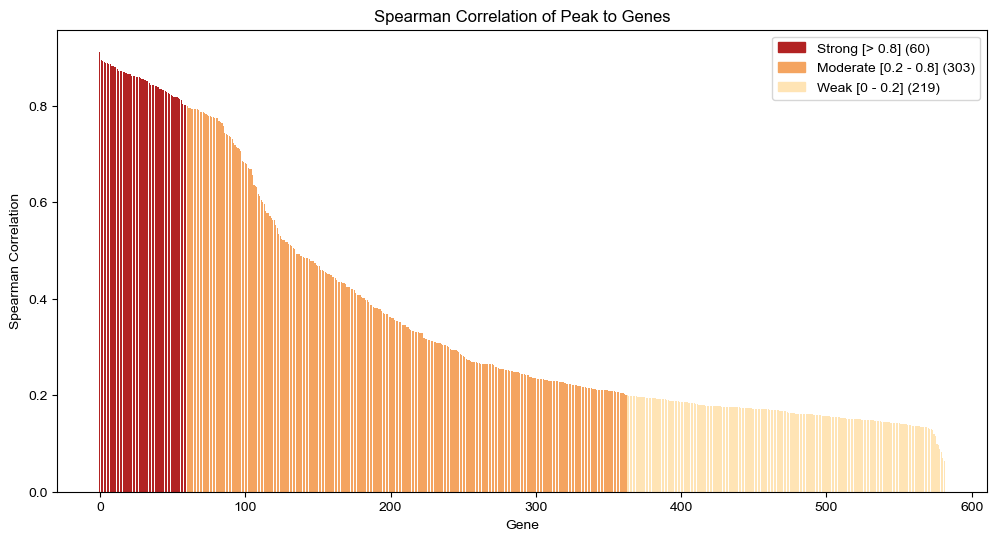

In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.unicode_minus']=False

# 定义相关性强度分类和颜色映射
def get_correlation_category(correlation):
    abs_corr = abs(correlation)
    if abs_corr >= 0.8:
        return 'Strong [> 0.8]'
    elif abs_corr >= 0.2:
        return 'Moderate [0.2 - 0.8]'
    else:
        return 'Weak [0 - 0.2]'

color_map = {
    'Strong [> 0.8]': '#B22222',
    'Moderate [0.2 - 0.8]': '#F4A460',
    'Weak [0 - 0.2]': '#FFE4B5',
}

# 为每个数据类型分配颜色和数量
results_df = pd.read_csv('/home/share/huadjyin/home/lutianyu/01HIV/02data/downstream/peak2gene/spearman_correlation.csv')
categories = results_df['Spearman_Correlation'].apply(lambda x: get_correlation_category(x))
colors = categories.apply(lambda x: color_map[x])
category_counts = categories.value_counts()

# 绘制柱状图
plt.figure(figsize=(12, 6))
plt.bar(range(len(results_df)), results_df['Spearman_Correlation'], color=colors)
plt.title('Spearman Correlation of Peak to Genes')
plt.xlabel('Gene')
plt.ylabel('Spearman Correlation')

# 添加图例
import matplotlib.patches as mpatches
patches = [mpatches.Patch(color=color_map[category], label=f'{category} ({category_counts[category]})') for category in color_map]
plt.legend(handles=patches)
#plt.savefig('/home/share/huadjyin/home/lutianyu/01HIV/02data/downstream/peak2gene/spearman.pdf', format='pdf')


看看不同spearman的特征有没有差异

In [3]:
import pandas as pd
spearman_df = pd.read_csv('/home/share/huadjyin/home/lutianyu/01HIV/02data/downstream/peak2gene/spearman_correlation.csv')
peak_df = pd.read_csv('/home/share/huadjyin/home/lutianyu/01HIV/02data/peak_gene/peak2gene_peaks_genesplit_filtered.csv')

In [4]:
# 定义分组
bins = [-1, 0.2, 0.8, 1]
labels = ['<0.2', '0.2-0.8', '>0.8']

# 添加分组列
spearman_df['Group'] = pd.cut(spearman_df['Spearman_Correlation'], bins=bins, labels=labels)

In [5]:
peak_count_df = peak_df.groupby('Matched_Gene').size().reset_index(name='Peak_Count')
merged_df = pd.merge(spearman_df, peak_count_df, left_on='Gene_Symbol', right_on='Matched_Gene')

In [6]:
# 定义分组的顺序
group_order = ['>0.8', '0.2-0.8', '<0.2']

# 将 Group 列转换为有序分类变量
merged_df['Group'] = pd.Categorical(
    merged_df['Group'], 
    categories=group_order, 
    ordered=True
)

# 按 Group 排序
merged_df = merged_df.sort_values('Group')

In [8]:
# 按 Group 分组
grouped_df = merged_df.groupby('Group')['Peak_Count'].apply(list).reset_index()
grouped_df

/tmp/ipykernel_973379/2102280525.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = merged_df.groupby('Group')['Peak_Count'].apply(list).reset_index()


,Group,Peak_Count
0,>0.8,"[14, 3, 6, 3, 38, 14, 7, 6, 52, 5, 11, 7, 10, ..."
1,0.2-0.8,"[9, 7, 35, 31, 5, 12, 2, 54, 39, 2, 4, 2, 23, ..."
2,<0.2,"[2, 14, 7, 4, 11, 11, 5, 9, 10, 5, 43, 2, 4, 4..."


In [9]:
import pandas as pd
import scipy.stats as stats

# 假设 merged_df 是已经处理好的数据框
# merged_df 包含列：Group, Peak_Count

# 定义分组顺序
group_order = ['>0.8', '0.2-0.8', '<0.2']

# 对每组数据进行正态性检验
for group in group_order:
    group_data = merged_df[merged_df['Group'] == group]['Peak_Count']
    
    # 进行 Shapiro-Wilk 检验
    stat, p_value = stats.shapiro(group_data)
    print(f"Group {group}:")
    print(f"  Shapiro-Wilk Test: p-value = {p_value:.4f}")
    
    # 进行 Kolmogorov-Smirnov 检验
    stat, p_value = stats.kstest(group_data, 'norm')
    print(f"  Kolmogorov-Smirnov Test: p-value = {p_value:.4f}")
    print()

Group >0.8:
  Shapiro-Wilk Test: p-value = 0.0000
  Kolmogorov-Smirnov Test: p-value = 0.0000

Group 0.2-0.8:
  Shapiro-Wilk Test: p-value = 0.0000
  Kolmogorov-Smirnov Test: p-value = 0.0000

Group <0.2:
  Shapiro-Wilk Test: p-value = 0.0000
  Kolmogorov-Smirnov Test: p-value = 0.0000



/tmp/ipykernel_973379/824368781.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


>0.8 vs. 0.2-0.8: Mann-Whitney-Wilcoxon test two-sided, P_val:2.724e-02 U_stat=1.073e+04
0.2-0.8 vs. <0.2: Mann-Whitney-Wilcoxon test two-sided, P_val:9.727e-04 U_stat=3.877e+04
>0.8 vs. <0.2: Mann-Whitney-Wilcoxon test two-sided, P_val:1.850e-05 U_stat=8.934e+03


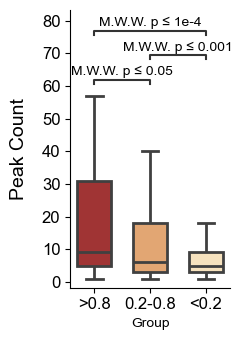

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from statannotations.Annotator import Annotator
import pandas as pd

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.unicode_minus']=False

# 假设 merged_df 是已经处理好的数据框
# merged_df 包含列：Group, Peak_Count

# 定义分组顺序和颜色
group_order = ['>0.8', '0.2-0.8', '<0.2']
colors = ['#B22222', '#F4A460', '#FFE4B5']

# 将 Group 列转换为有序分类变量
merged_df['Group'] = pd.Categorical(
    merged_df['Group'], 
    categories=group_order, 
    ordered=True
)

# 按 Group 排序
merged_df = merged_df.sort_values('Group')

# 设置图形大小
plt.figure(figsize=(2.5, 3.5))

# 绘制箱线图
ax = sns.boxplot(
    x='Group', 
    y='Peak_Count', 
    data=merged_df, 
    palette=colors,  # 使用指定颜色
    showfliers=False,  # 去掉离群点
    width=0.6,  # 调整箱线宽度
    linewidth=2,  # 调整边框线宽
)


plt.ylabel(
    'Peak Count', 
    fontsize=14, 
    fontweight='bold', 
    labelpad=10
)

# 调整坐标轴字体大小
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 设置背景为白色，去掉顶部和右侧边框
sns.despine(top=True, right=True)

# 定义组间比较的组合
pairs = [
    ('>0.8', '0.2-0.8'),
    ('0.2-0.8', '<0.2'),
    ('>0.8', '<0.2'),
]

# 初始化 Annotator
annotator = Annotator(
    ax, 
    pairs, 
    data=merged_df, 
    x='Group', 
    y='Peak_Count'
)

# 配置统计检验为 Wilcoxon秩和检验（Mann-Whitney U检验）
annotator.configure(
    test='Mann-Whitney',  # 使用 Wilcoxon秩和检验
    text_format='simple',  # 简单格式显示 p 值
    loc='inside',  # 将 p 值标注在箱线图内部
    verbose=2  # 打印详细信息
)

# 计算 p 值并添加到图中
annotator.apply_and_annotate()
#plt.savefig('/home/share/huadjyin/home/lutianyu/01HIV/02data/downstream/peak2gene/spearman_peakcount.pdf', format='pdf')
# 显示图形
plt.tight_layout()
plt.show()

In [12]:
from statsmodels.stats.multitest import multipletests
group_order = ['>0.8', '0.2-0.8', '<0.2']

# Convert Group column to ordered categorical (optional for calculation, but good practice)
merged_df['Group'] = pd.Categorical(
    merged_df['Group'], 
    categories=group_order, 
    ordered=True
)

# Define pairs for comparison
pairs = [
    ('>0.8', '0.2-0.8'),
    ('0.2-0.8', '<0.2'),
    ('>0.8', '<0.2'),
]

# Perform Mann-Whitney U tests and collect raw P-values
raw_p_values = []
comparison_labels = []

print("--- Raw P-values from Mann-Whitney U Tests ---")
for pair in pairs:
    group1_name, group2_name = pair[0], pair[1]
    group1_data = merged_df[merged_df['Group'] == group1_name]['Peak_Count']
    group2_data = merged_df[merged_df['Group'] == group2_name]['Peak_Count']
    
    # Perform Mann-Whitney U test (non-parametric, suitable for non-normal data or unequal variances)
    # 'alternative="two-sided"' is common for general differences
    statistic, p_value = stats.mannwhitneyu(group1_data, group2_data, alternative='two-sided')
    
    raw_p_values.append(p_value)
    label = f"{group1_name} vs {group2_name}"
    comparison_labels.append(label)
    print(f"{label}: P-value = {p_value:.4f}")

# Apply P-value Correction (FDR)
reject, pvals_corrected, _, _ = multipletests(raw_p_values, alpha=0.05, method='fdr_bh')

print("\n--- Corrected P-values (Benjamini-Hochberg FDR) ---")
for i, label in enumerate(comparison_labels):
    corrected_p = pvals_corrected[i]
    is_significant = " (Significant)" if reject[i] else " (Not Significant)"
    print(f"{label}: Corrected P-value = {corrected_p:.4f}{is_significant}")

results_df = pd.DataFrame({
    'Comparison': comparison_labels,
    'Raw_P_value': raw_p_values,
    'Corrected_P_value': pvals_corrected,
    'Significant_FDR_0.05': reject
})

print(results_df)

--- Raw P-values from Mann-Whitney U Tests ---
>0.8 vs 0.2-0.8: P-value = 0.0272
0.2-0.8 vs <0.2: P-value = 0.0010
>0.8 vs <0.2: P-value = 0.0000

--- Corrected P-values (Benjamini-Hochberg FDR) ---
>0.8 vs 0.2-0.8: Corrected P-value = 0.0272 (Significant)
0.2-0.8 vs <0.2: Corrected P-value = 0.0015 (Significant)
>0.8 vs <0.2: Corrected P-value = 0.0001 (Significant)
        Comparison  Raw_P_value  Corrected_P_value  Significant_FDR_0.05
0  >0.8 vs 0.2-0.8     0.027237           0.027237                  True
1  0.2-0.8 vs <0.2     0.000973           0.001459                  True
2     >0.8 vs <0.2     0.000018           0.000055                  True


### top60个gene的全局peak热图

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [14]:
# 1. 读取并筛选 Spearman 相关性数据
correlation_df = pd.read_csv('/home/share/huadjyin/home/lutianyu/01HIV/02data/downstream/peak2gene/spearman_correlation.csv')
selected_genes = correlation_df[correlation_df['Spearman_Correlation'] > 0.8]['Gene_Symbol'].tolist()

# 2. 读取并筛选 00summary.txt 数据
summary_df = pd.read_csv('/home/share/huadjyin/home/lutianyu/01HIV/02data/all_filtered/00summary.txt', sep='\t')
filtered_summary_df = summary_df[summary_df['symbol'].isin(selected_genes)]

In [15]:
import pandas as pd
import re


def sort_peakname(df):
    def extract_chrom_and_pos(peakname):
        match = re.match(r'(chr\w+):(\d+)-(\d+)', peakname)
        if match:
            chrom = match.group(1)
            start = int(match.group(2))
            return chrom, start
        else:
            return None, None

    # 提取染色体编号和起始位置
    df[['chrom', 'start']] = df['peakname'].apply(lambda x: pd.Series(extract_chrom_and_pos(x)))

    # 定义染色体排序的顺序
    chrom_order = ['chr' + str(i) for i in range(1, 23)] + ['chrX', 'chrY']
    chrom_order_dict = {chrom: i for i, chrom in enumerate(chrom_order)}

    # 添加染色体排序的数值列
    df['chrom_order'] = df['chrom'].map(chrom_order_dict)
    df = df.sort_values(by=['chrom_order', 'start'])
    df = df.drop(columns=['chrom', 'start', 'chrom_order'])
    return df

filtered_summary_df_sorted = sort_peakname(filtered_summary_df.copy())
print(filtered_summary_df_sorted)


        symbol                peakname  peakweight
3728  TNFRSF1B  chr1:11926239-11926740    0.216545
3726  TNFRSF1B  chr1:11979937-11980438    0.085496
3724  TNFRSF1B  chr1:12019124-12019625    0.158782
3731  TNFRSF1B  chr1:12132946-12133447    0.049450
3732  TNFRSF1B  chr1:12150411-12150912    0.025527
...        ...                     ...         ...
3604      SAT1  chrX:24025247-24025748    0.070606
3380      ATRX  chrX:77786004-77786505    0.107028
3382      ATRX  chrX:77895259-77895760    0.027834
3379      ATRX  chrX:77899054-77899555    0.003985
3381      ATRX  chrX:77910299-77910800    0.005052

[1101 rows x 3 columns]


In [16]:
import pandas as pd

def normalize_peakweight_within_gene(df):
    def normalize_group(group):
        min_val = group['peakweight'].min()
        max_val = group['peakweight'].max()

        if min_val == max_val:
            group['peakweight_normalized'] = 0
        else:
            group['peakweight_normalized'] = (group['peakweight'] - min_val) / (max_val - min_val) * 2 - 1
        return group

    df = df.groupby('symbol').apply(normalize_group)
    df = df.drop(columns=['peakweight'])
    df = df.rename(columns={'peakweight_normalized':'peakweight'})

    return df

filtered_summary_df_normalized = normalize_peakweight_within_gene(filtered_summary_df_sorted.copy())
print(filtered_summary_df_normalized)

               symbol                 peakname  peakweight
symbol                                                    
ANKRD11 6819  ANKRD11  chr16:89031907-89032408   -0.370456
        6810  ANKRD11  chr16:89096889-89097390   -0.388522
        6823  ANKRD11  chr16:89115172-89115673   -0.475318
        6817  ANKRD11  chr16:89171408-89171909   -0.917359
        6818  ANKRD11  chr16:89217412-89217913   -1.000000
...               ...                      ...         ...
ZFP36   6769    ZFP36  chr19:39435830-39436331   -0.827448
        6777    ZFP36  chr19:39445345-39445846   -0.721939
        6772    ZFP36  chr19:39480542-39481043   -0.898527
        6765    ZFP36  chr19:39532682-39533183   -0.438500
        6764    ZFP36  chr19:39539989-39540490   -0.738829

[1101 rows x 3 columns]


/tmp/ipykernel_973379/2457133799.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('symbol').apply(normalize_group)


In [17]:
import pandas as pd
import re

def sort_peakname2(df):
    def extract_chrom_and_pos(peakname):
        match = re.match(r'(chr\w+):(\d+)-(\d+)', peakname)
        if match:
            chrom = match.group(1)
            start = int(match.group(2))
            return chrom, start
        else:
            return None, None

    # 提取染色体编号和起始位置
    df[['chrom', 'start']] = df['peakname'].apply(lambda x: pd.Series(extract_chrom_and_pos(x)))

    # 定义染色体排序的顺序
    chrom_order = ['chr' + str(i) for i in range(1, 23)] + ['chrX', 'chrY']
    chrom_order_dict = {chrom: i for i, chrom in enumerate(chrom_order)}

    # 添加染色体排序的数值列
    df['chrom_order'] = df['chrom'].map(chrom_order_dict)

    # 排序
    df = df.sort_values(by=['chrom_order', 'start'])

    # 删除辅助列
    df = df.drop(columns=['chrom', 'start', 'chrom_order'])

    return df


filtered_summary_df_sorted_by_peak = sort_peakname2(filtered_summary_df_normalized.copy())
print(filtered_summary_df_sorted_by_peak)


                 symbol                peakname  peakweight
symbol                                                     
TNFRSF1B 3728  TNFRSF1B  chr1:11926239-11926740   -0.428397
         3726  TNFRSF1B  chr1:11979937-11980438   -0.820547
         3724  TNFRSF1B  chr1:12019124-12019625   -0.601245
         3731  TNFRSF1B  chr1:12132946-12133447   -0.928412
         3732  TNFRSF1B  chr1:12150411-12150912   -1.000000
...                 ...                     ...         ...
SAT1     3604      SAT1  chrX:24025247-24025748    1.000000
ATRX     3380      ATRX  chrX:77786004-77786505    1.000000
         3382      ATRX  chrX:77895259-77895760   -0.537095
         3379      ATRX  chrX:77899054-77899555   -1.000000
         3381      ATRX  chrX:77910299-77910800   -0.979277

[1101 rows x 3 columns]


In [18]:
filtered_summary_df_no_index = filtered_summary_df_sorted_by_peak.reset_index(drop=True)

In [ ]:
symbol_order = filtered_summary_df_no_index['symbol'].unique()
peakname_order = filtered_summary_df_no_index['peakname'].unique()

# 透视操作
pivot_df = filtered_summary_df_no_index.pivot_table(index='symbol', columns='peakname', values='peakweight')
# 按照原始顺序重新索引 pivot_df 的行和列
pivot_df = pivot_df.reindex(index=symbol_order, columns=peakname_order)
print(pivot_df)

peakname  chr1:11926239-11926740  chr1:11979937-11980438  \
symbol                                                     
TNFRSF1B               -0.428397               -0.820547   
MACF1                        NaN                     NaN   
CTSS                         NaN                     NaN   
S100A10                      NaN                     NaN   
S100A4                       NaN                     NaN   
PRRC2C                       NaN                     NaN   
TPR                          NaN                     NaN   
ARID4B                       NaN                     NaN   
PLEK                         NaN                     NaN   
IGKC                         NaN                     NaN   
CXCR4                        NaN                     NaN   
PPIG                         NaN                     NaN   
ARL4C                        NaN                     NaN   
NKTR                         NaN                     NaN   
FOXP1                        NaN        

In [20]:
pivot_df

peakname,chr1:11926239-11926740,chr1:11979937-11980438,chr1:12019124-12019625,chr1:12132946-12133447,chr1:12150411-12150912,chr1:12153218-12153719,chr1:12161744-12162245,chr1:12173645-12174146,chr1:12178042-12178543,chr1:12179027-12179528,...,chr22:37849145-37849646,chrX:23743120-23743621,chrX:23781213-23781714,chrX:23782909-23783410,chrX:23907762-23908263,chrX:24025247-24025748,chrX:77786004-77786505,chrX:77895259-77895760,chrX:77899054-77899555,chrX:77910299-77910800
symbol,,,,,,,,,,,,,,,,,,,,,
TNFRSF1B,-0.428397,-0.820547,-0.601245,-0.928412,-1.0,1.0,-0.776169,-0.98162,-0.915354,-0.969143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MACF1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CTSS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S100A10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S100A4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PRRC2C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TPR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ARID4B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PLEK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


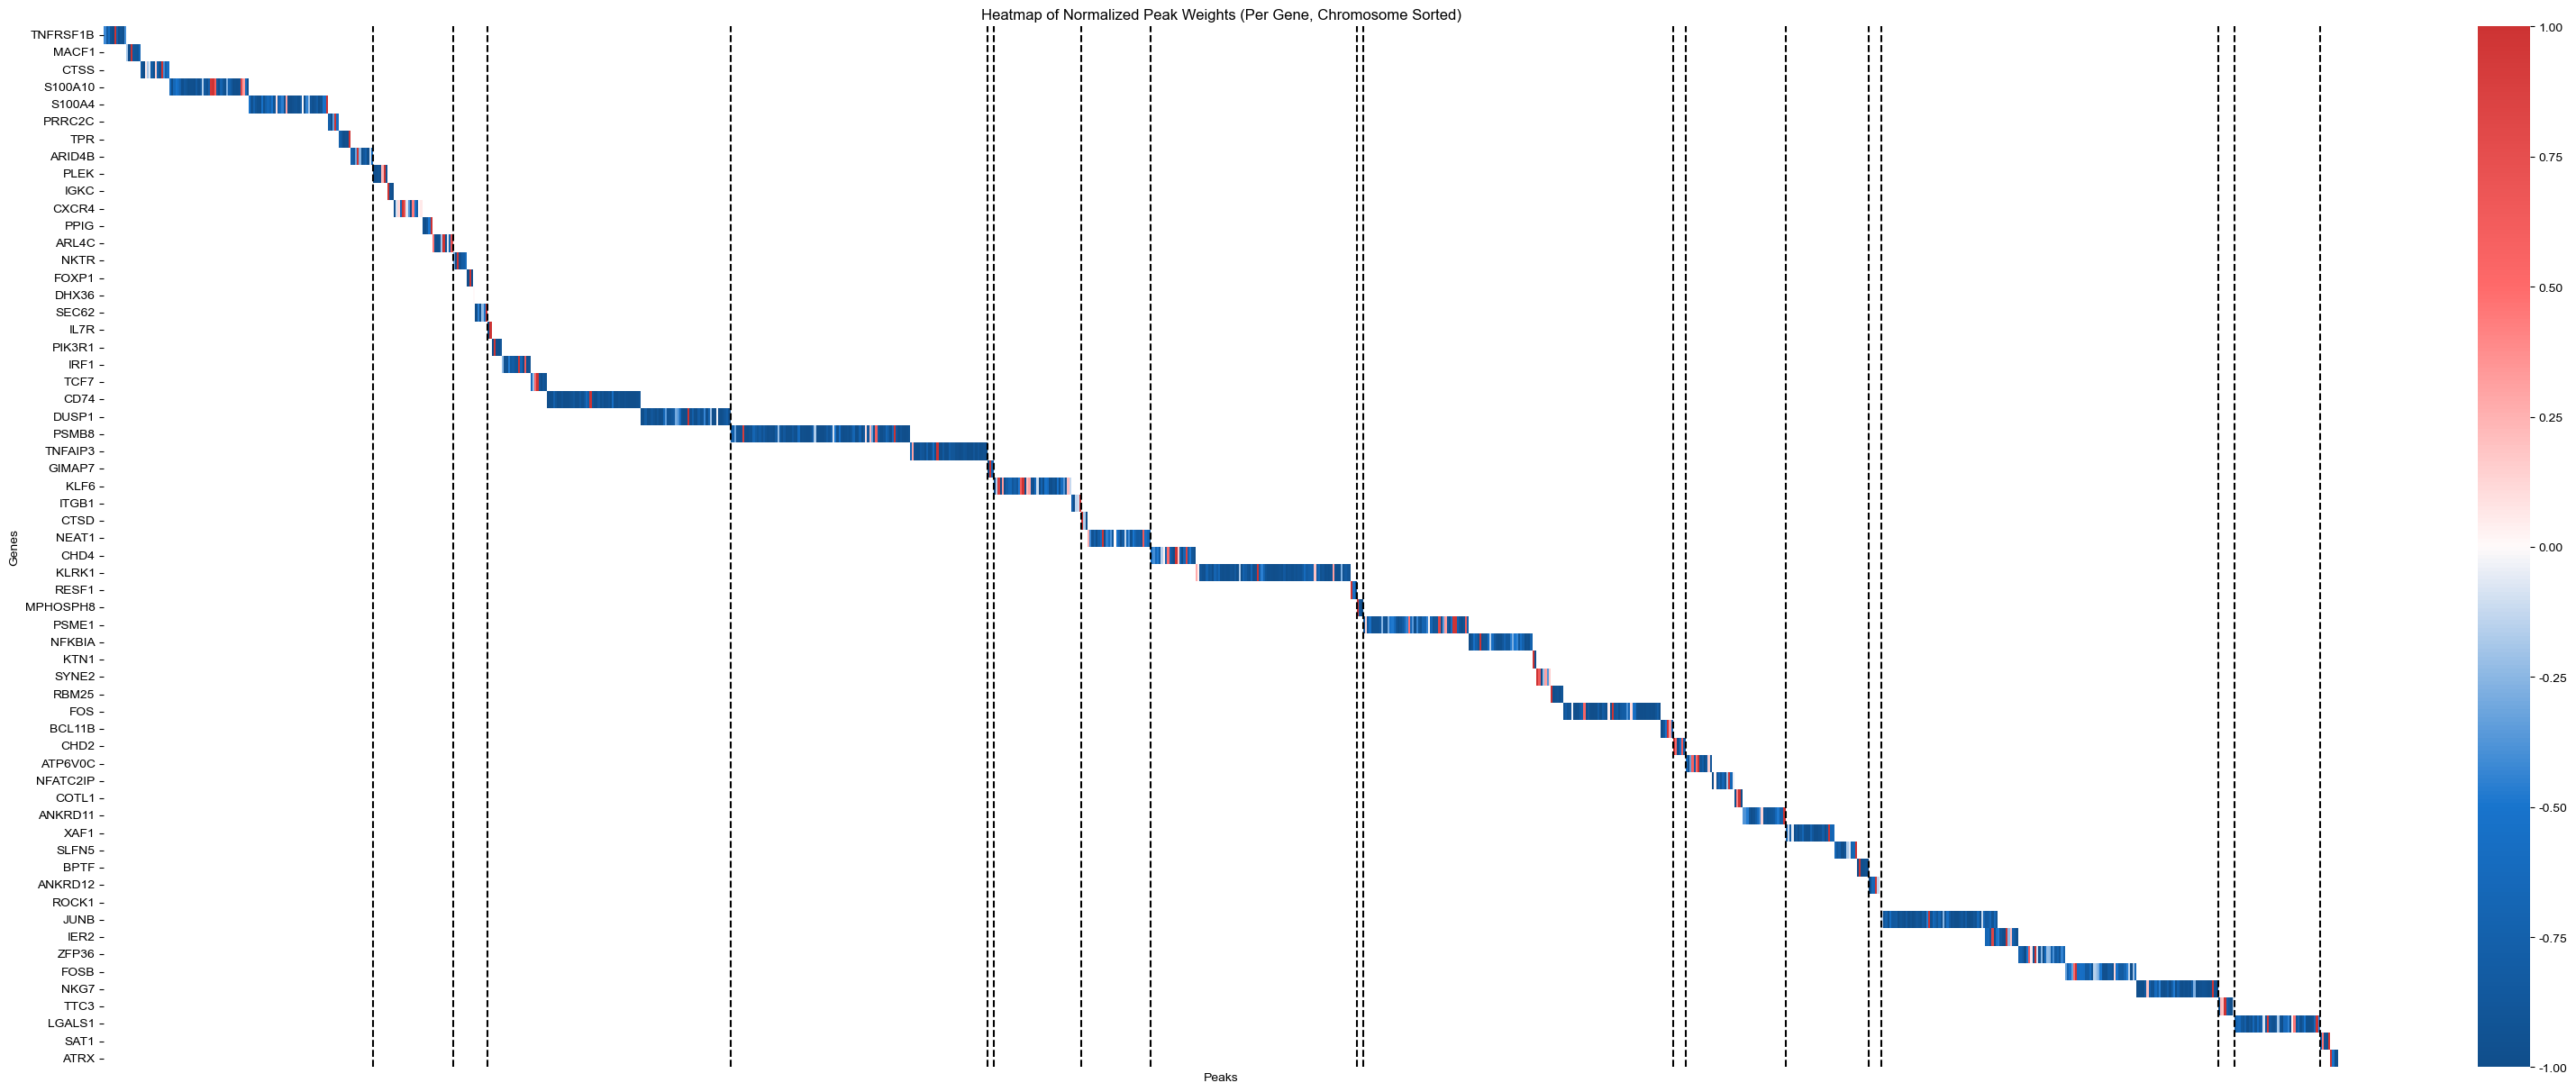

In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.unicode_minus']=False

colors = ["#104E8B", "#1874CD", "#FFFAFA", "#FF6A6A", "#CD3333"]
cmap = LinearSegmentedColormap.from_list("my_colormap", colors)
# 绘制热图
plt.figure(figsize=(40, 15))
sns.heatmap(pivot_df, cmap=cmap, xticklabels=False)
plt.title('Heatmap of Normalized Peak Weights (Per Gene, Chromosome Sorted)')
plt.xlabel('Peaks')
plt.ylabel('Genes')

# 提取染色体信息
def extract_chromosome(peakname):
    match = re.search(r'chr(\w+):', peakname)
    if match:
        chrom = match.group(1)
        if chrom == 'X':
            return 23
        elif chrom == 'Y':
            return 24
        else:
            try:
                return int(chrom)
            except ValueError:
                return 25 
    else:
        return 26

# 划分染色体区域
chromosome_boundaries = []
current_chromosome = None
for i, peakname in enumerate(pivot_df.columns):
    chromosome = extract_chromosome(peakname)
    if chromosome != current_chromosome:
        chromosome_boundaries.append(i)
        current_chromosome = chromosome

for boundary in chromosome_boundaries[1:]:
    plt.axvline(x=boundary, color='black', linestyle='--')

output_path = f'/home/share/huadjyin/home/lutianyu/01HIV/02data/downstream/peak2gene/overall_peakgradient.pdf'
#plt.savefig(output_path, format='pdf', bbox_inches='tight')
plt.show()
